In [2]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle
from pathlib import Path
from importlib import reload
from IPython.display import clear_output

from roman_cgi_iefc import cgi
from roman_cgi_iefc import iefc_utils as iefcu
from roman_cgi_iefc import iefc_sim as iefc

import misc

import proper
proper.prop_use_fftw(DISABLE=False)
# proper.prop_fftw_wisdom( 1024 ) 

data_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
flatmaps_dir = Path.home()/'src/pyfalco/roman/flatmaps'

dm1_flatmap = fits.getdata(flatmaps_dir/'dm1_m_flat_hlc_band1.fits')
dm2_flatmap = fits.getdata(flatmaps_dir/'dm2_m_flat_hlc_band1.fits')
dm1_design = fits.getdata(flatmaps_dir/'dm1_m_design_hlc_band1.fits')
dm2_design = fits.getdata(flatmaps_dir/'dm2_m_design_hlc_band1.fits')

In [3]:
reload(cgi)

hlci = cgi.CGI_PROPER(use_opds=False, use_fieldstop=False, quiet=True)
npsf = hlci.npsf
Nact = hlci.Nact

# Create dark hole ROI to calibrate and control

(4096,) (4096,) (4096,) (4096,)


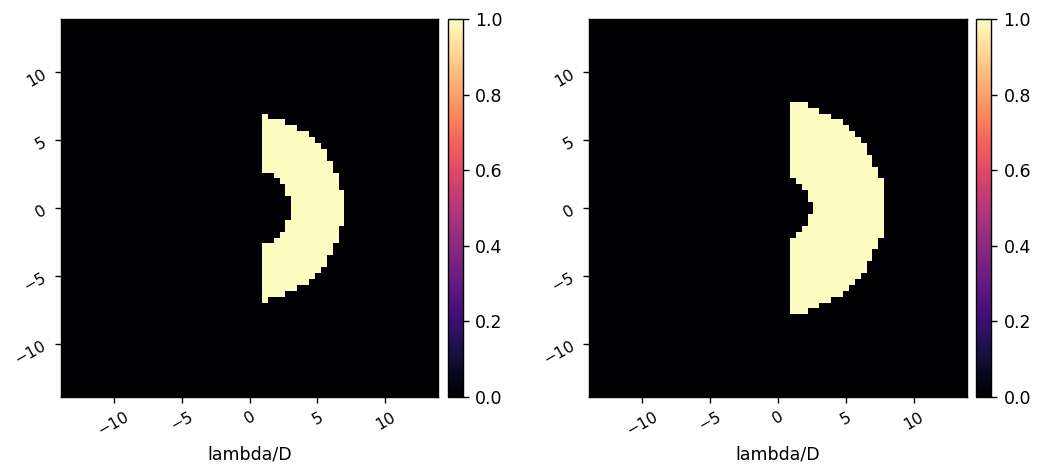

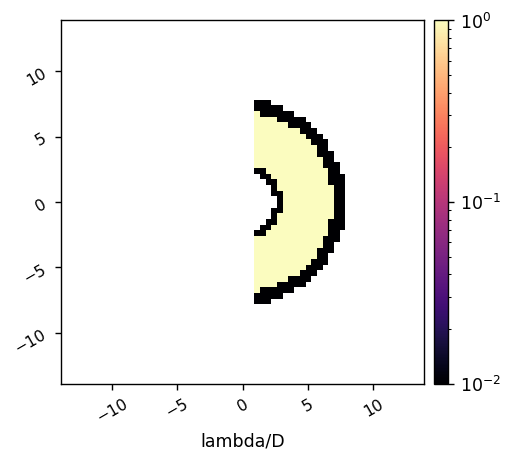

In [4]:
reload(iefcu)
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * hlci.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 1
iwa = 3
owa = 7

# Create the mask that is used to select which region to make dark.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
    'direction' : '+x'
}
dh_mask = iefcu.create_annular_focal_plane_mask(xf, yf, dh_params).ravel()

#Create the mask that is used to select which region to make dark.
control_params = {
    'inner_radius' : iwa-0.5,
    'outer_radius' : owa+1,
    'edge_position' : edge,
    'direction' : '+x'
}
control_mask = iefcu.create_annular_focal_plane_mask(xf, yf, control_params).ravel()

relative_weight = 0.99
weights = dh_mask * relative_weight + (1 - relative_weight) * control_mask

print(dh_mask.shape, control_mask.shape, control_mask.shape, weights.shape)
misc.myimshow2(dh_mask.reshape(npsf,npsf), control_mask.reshape(npsf,npsf), 
               pxscl1=hlci.psf_pixelscale_lamD, pxscl2=hlci.psf_pixelscale_lamD)
misc.myimshow(weights.reshape(npsf,npsf), lognorm=True, pxscl=hlci.psf_pixelscale_lamD)

# Create probe and fourier modes

Creating Fourier modes:  (64, 64)
Calibration modes required: 192


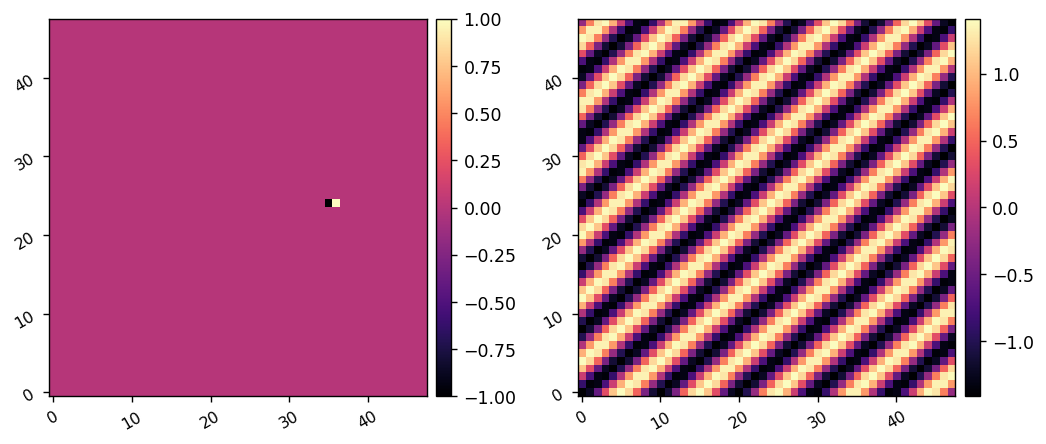

In [5]:
reload(iefc)

fourier_modes, fx, fy = iefcu.create_fourier_modes(xfp, control_mask.reshape((npsf,npsf)), Nact, circular_mask=False)
probe_modes = iefcu.create_probe_poke_modes(Nact, 3*Nact//4, Nact//2, 3*Nact//4-1, Nact//2)

calibration_amplitude = 0.006 * hlci.wavelength.to(u.m).value
probe_amplitude = 0.05 * hlci.wavelength.to(u.m).value
nmodes = fourier_modes.shape[0]

print('Calibration modes required: {:d}'.format(nmodes))
calibration_mode = fourier_modes[10]
misc.myimshow2((probe_modes[0] - probe_modes[1]).reshape((Nact,Nact)), calibration_mode.reshape(Nact,Nact))

# Calibrate IEFC (or load in previous calibration data)

In [ ]:
reload(iefc)

response_cube, calibration_cube = iefc.calibrate(hlci, probe_amplitude, probe_modes, 
                                                 calibration_amplitude, fourier_modes, DM=2, start_mode=0)

Calibrating I-EFC...
	Calibrated mode 1 / 192 in 20.283s
	Calibrated mode 2 / 192 in 40.295s
	Calibrated mode 3 / 192 in 60.815s
	Calibrated mode 4 / 192 in 82.781s
	Calibrated mode 5 / 192 in 106.703s
	Calibrated mode 6 / 192 in 127.309s
	Calibrated mode 7 / 192 in 145.549s
	Calibrated mode 8 / 192 in 165.380s
	Calibrated mode 9 / 192 in 184.559s
	Calibrated mode 10 / 192 in 204.609s
	Calibrated mode 11 / 192 in 225.368s
	Calibrated mode 12 / 192 in 244.897s
	Calibrated mode 13 / 192 in 263.911s


In [ ]:
print(response_cube.shape, calibration_cube.shape)

response_hdu = fits.PrimaryHDU(data=response_cube)
response_hdu.writeto(data_dir/'response-data'/'hlc_response_cube_ann_mask.fits', overwrite=True)

calib_hdu = fits.PrimaryHDU(data=calibration_cube)
calib_hdu.writeto(data_dir/'calibration-data'/'hlc_calibration_cube_ann_mask.fits', overwrite=True)

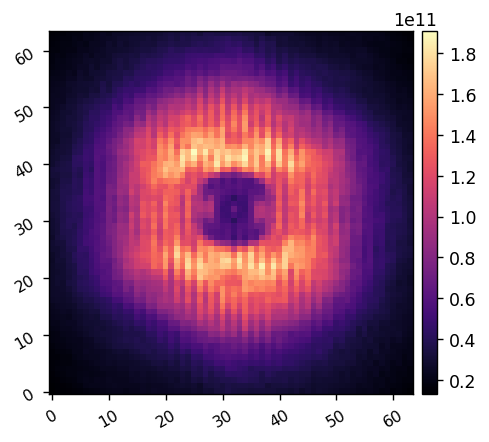

In [5]:
im = np.sum(abs(response_cube), axis=(0,1))
misc.myimshow(im.reshape(64,64))